In [ ]:
# #NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
# #    This code is only here to check that your internet is enabled. It doesn't do anything else.
# #    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

# import socket,warnings
# try:
#     socket.setdefaulttimeout(1)
#     socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
# except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [4]:
# #hide
# ! [ -e /content ] && 
!pip install -Uqq fastbook
from fastcore.all import *
import fastbook
fastbook.setup_book()

In [5]:
#hide
from fastbook import *
from fastcore.all import *

The first line imports all of the fastai.vision library.
```python
from fastai.vision.all import *
```
This gives us all of the functions and classes we will need to create a wide variety of computer vision models.

The second line downloads a standard dataset from the [fast.ai datasets collection](https://course.fast.ai/datasets) (if not previously downloaded) to your server, extracts it (if not previously extracted), and returns a `Path` object with the extracted location:

```python
path = untar_data(URLs.PETS)/'images'
```

In [6]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

It will only do this download once, and return the location of the decompressed archive. We can check what is inside with the .ls() method.

In [7]:
path.ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_115.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_18.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_157.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_28.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_6.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_79.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_128.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_265.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_182.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_89.jpg')...]

We will ignore the annotations folder for now, and focus on the images one. get_image_files is a fastai function that helps us grab all the image files (recursively) in one folder.

In [8]:
files = get_image_files("./images")
len(files)

0

In the third line we define a function, `is_cat`, which labels cats based on a filename rule provided by the dataset creators:
```python
def is_cat(x): return x[0].isupper()
```

In [9]:
def is_cat(x): return x[0].isupper()

We use that function in the fourth line, which tells fastai what kind of dataset we have and how it is structured:

```python
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))
```

There are various different classes for different kinds of deep learning datasets and problems—here we're using `ImageDataLoaders`. The first part of the class name will generally be the type of data you have, such as image, or text.

The other important piece of information that we have to tell fastai is how to get the labels from the dataset. Computer vision datasets are normally structured in such a way that the label for an image is part of the filename, or path—most commonly the parent folder name. fastai comes with a number of standardized labeling methods, and ways to write your own. Here we're telling fastai to use the `is_cat` function we just defined.

Finally, we define the `Transform`s that we need. A `Transform` contains code that is applied automatically during training; fastai includes many predefined `Transform`s, and adding new ones is as simple as creating a Python function. There are two kinds: `item_tfms` are applied to each item (in this case, each item is resized to a 224-pixel square), while `batch_tfms` are applied to a *batch* of items at a time using the GPU, so they're particularly fast (we'll see many examples of these throughout this book).

Why 224 pixels? This is the standard size for historical reasons (old pretrained models require this size exactly), but you can pass pretty much anything. If you increase the size, you'll often get a model with better results (since it will be able to focus on more details), but at the price of speed and memory consumption; the opposite is true if you decrease the size. 

The Pet dataset contains 7,390 pictures of dogs and cats, consisting of 37 different breeds. Each image is labeled using its filename: for instance the file *great\_pyrenees\_173.jpg* is the 173rd example of an image of a Great Pyrenees breed dog in the dataset. The filenames start with an uppercase letter if the image is a cat, and a lowercase letter otherwise. We have to tell fastai how to get labels from the filenames, which we do by calling `from_name_func` (which means that labels can be extracted using a function applied to the filename), and passing `is_cat`, which returns `x[0].isupper()`, which evaluates to `True` if the first letter is uppercase (i.e., it's a cat).

The most important parameter to mention here is `valid_pct=0.2`. This tells fastai to hold out 20% of the data and *not use it for training the model at all*. This 20% of the data is called the *validation set*; the remaining 80% is called the *training set*. The validation set is used to measure the accuracy of the model. By default, the 20% that is held out is selected randomly. The parameter `seed=42` sets the *random seed* to the same value every time we run this code, which means we get the same validation set every time we run it—this way, if we change our model and retrain it, we know that any differences are due to the changes to the model, not due to having a different random validation set.

fastai will *always* show you your model's accuracy using *only* the validation set, *never* the training set. This is absolutely critical, because if you train a large enough model for a long enough time, it will eventually memorize the label of every item in your dataset! The result will not actually be a useful model, because what we care about is how well our model works on *previously unseen images*. That is always our goal when creating a model: for it to be useful on data that the model only sees in the future, after it has been trained.

Even when your model has not fully memorized all your data, earlier on in training it may have memorized certain parts of it. As a result, the longer you train for, the better your accuracy will get on the training set; the validation set accuracy will also improve for a while, but eventually it will start getting worse as the model starts to memorize the training set, rather than finding generalizable underlying patterns in the data. When this happens, we say that the model is *overfitting*.

In [10]:
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

We can then check if everything looks okay with the show_batch method (True is for cat, False is for dog):

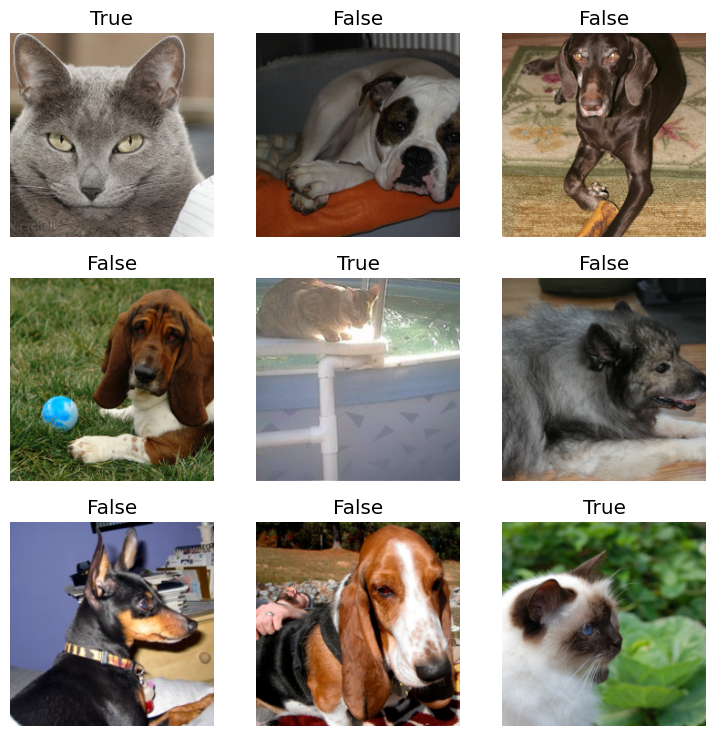

In [11]:
dls.show_batch()

The fifth line of the code training our image recognizer tells fastai to create a *convolutional neural network* (CNN) and specifies what *architecture* to use (i.e. what kind of model to create), what data we want to train it on, and what *metric* to use:

```python
learn = vision_learner(dls, resnet34, metrics=error_rate)
```

In [12]:
# Step 5: Create the Learner
learn = vision_learner(dls, resnet34, metrics=[error_rate, RocAucBinary()])

# Step 6: Train the model
learn.fine_tune(2)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 189MB/s]


In [13]:
?vision_learner

Signature:
vision_learner(
    dls,
    arch,
    normalize=True,
    n_out=None,
    pretrained=True,
    loss_func=None,
    opt_func=<function Adam at 0x78a30fccbb50>,
    lr=0.001,
    splitter=None,
    cbs=None,
    metrics=None,
    path=None,
    model_dir='models',
    wd=None,
    wd_bn_bias=False,
    train_bn=True,
    moms=(0.95, 0.85, 0.95),
    cut=None,
    init=<function kaiming_normal_ at 0x78a36d7f7250>,
    custom_head=None,
    concat_pool=True,
    pool=True,
    lin_ftrs=None,
    ps=0.5,
    first_bn=True,
    bn_final=False,
    lin_first=False,
    y_range=None,
    *,
    n_in=3,
)
Docstring: Build a vision learner from `dls` and `arch`
File:      /opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py
Type:      function

### Sidebar: This Book Was Written in Jupyter Notebooks

In [14]:
1+1

2

In [ ]:
img = PILImage.create(image_cat())
img.to_thumb(192)

### End sidebar

In [11]:
uploader_dog = widgets.FileUpload()
uploader_dog

FileUpload(value=(), description='Upload')

In [13]:
uploader_cat = widgets.FileUpload()
uploader_cat

FileUpload(value=(), description='Upload')

In [14]:
#hide
# For the book, we can't actually click an upload button, so we fake it
uploader_dog = SimpleNamespace(data = ['dog.jpeg'])
uploader_dog

namespace(data=['dog.jpeg'])

In [16]:
img = PILImage.create(uploader_dog.data[0])
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a dog: {probs[0].item():.6f}")

Is this a cat?: False.

Probability it's a dog: 0.999991


In [17]:
#hide
# For the book, we can't actually click an upload button, so we fake it
uploader_cat = SimpleNamespace(data = ['cat.jpg'])
uploader_cat

namespace(data=['cat.jpg'])

In [18]:
img = PILImage.create(uploader_cat.data[0])
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: True.

Probability it's a cat: 1.000000


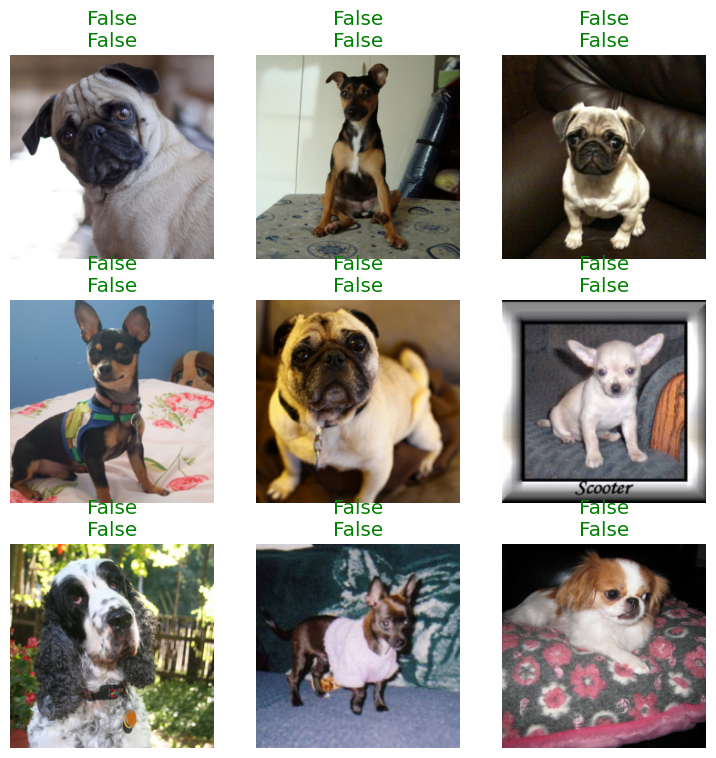

In [15]:
learn.show_results()

## Classifying breeds
To label our data with the breed name, we will use a regular expression to extract it from the filename. Looking back at a filename, we have:

so the class is everything before the last _ followed by some digits. A regular expression that will catch the name is thus:

In [19]:
pat = r'^(.*)_\d+.jpg'

Since classifying the exact breed of cats or dogs amongst 37 different breeds is a harder problem, we will slightly change the definition of our DataLoaders to use data augmentation:

In [20]:
dls_2 = ImageDataLoaders.from_name_re(path, get_image_files(path), pat, valid_pct=0.2, seed=42, item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

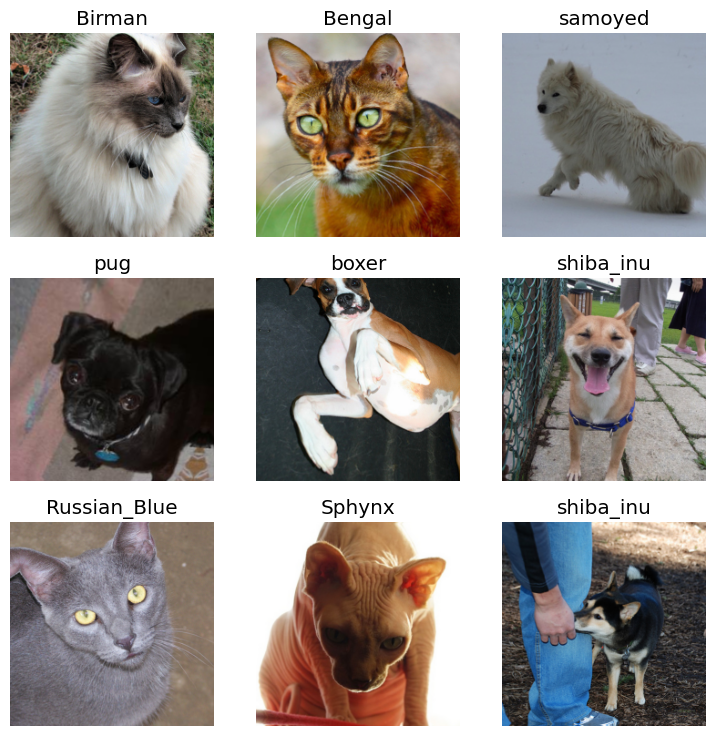

In [21]:
dls_2.show_batch()

We can then create our Learner exactly as before and train our model. We used the default learning rate before, but we might want to find the best one possible. For this, we can use the learning rate finder:

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0004786300996784121)

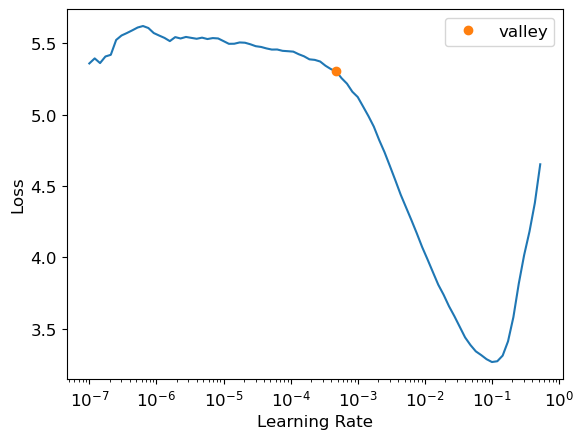

In [30]:
learn_2 = vision_learner(dls_2, resnet34, metrics= error_rate)
learn_2.lr_find()

It plots the graph of the learning rate finder and gives us two suggestions (minimum divided by 10 and steepest gradient). Let’s use 3e-3 here. We will also do a bit more epochs:

In [31]:
learn_2.fine_tune(2, 3e-3)

Again, we can have a look at some predictions with show_results:

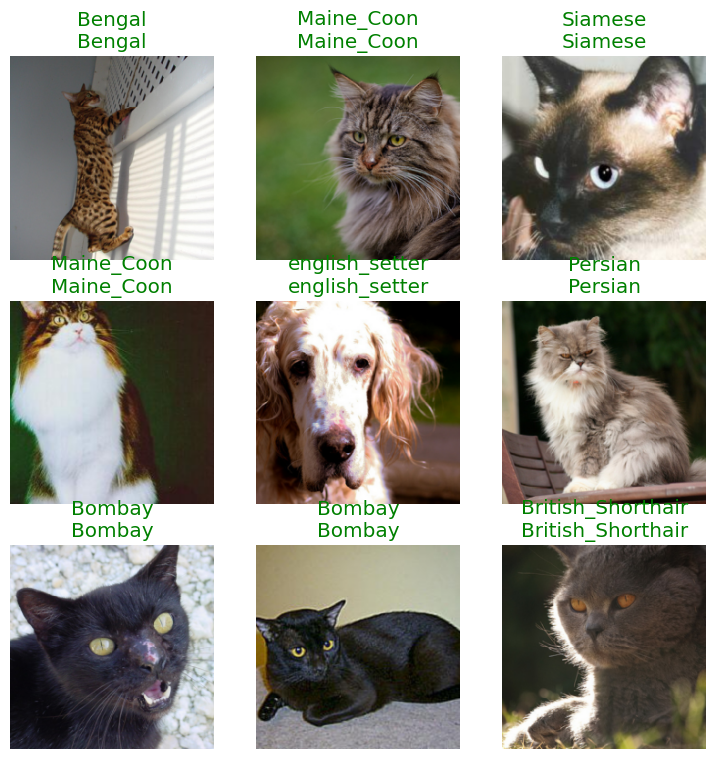

In [32]:
learn_2.show_results()

Another thing that is useful is an interpretation object, it can show us where the model made the worse predictions:

In [33]:
interp = Interpretation.from_learner(learn_2)

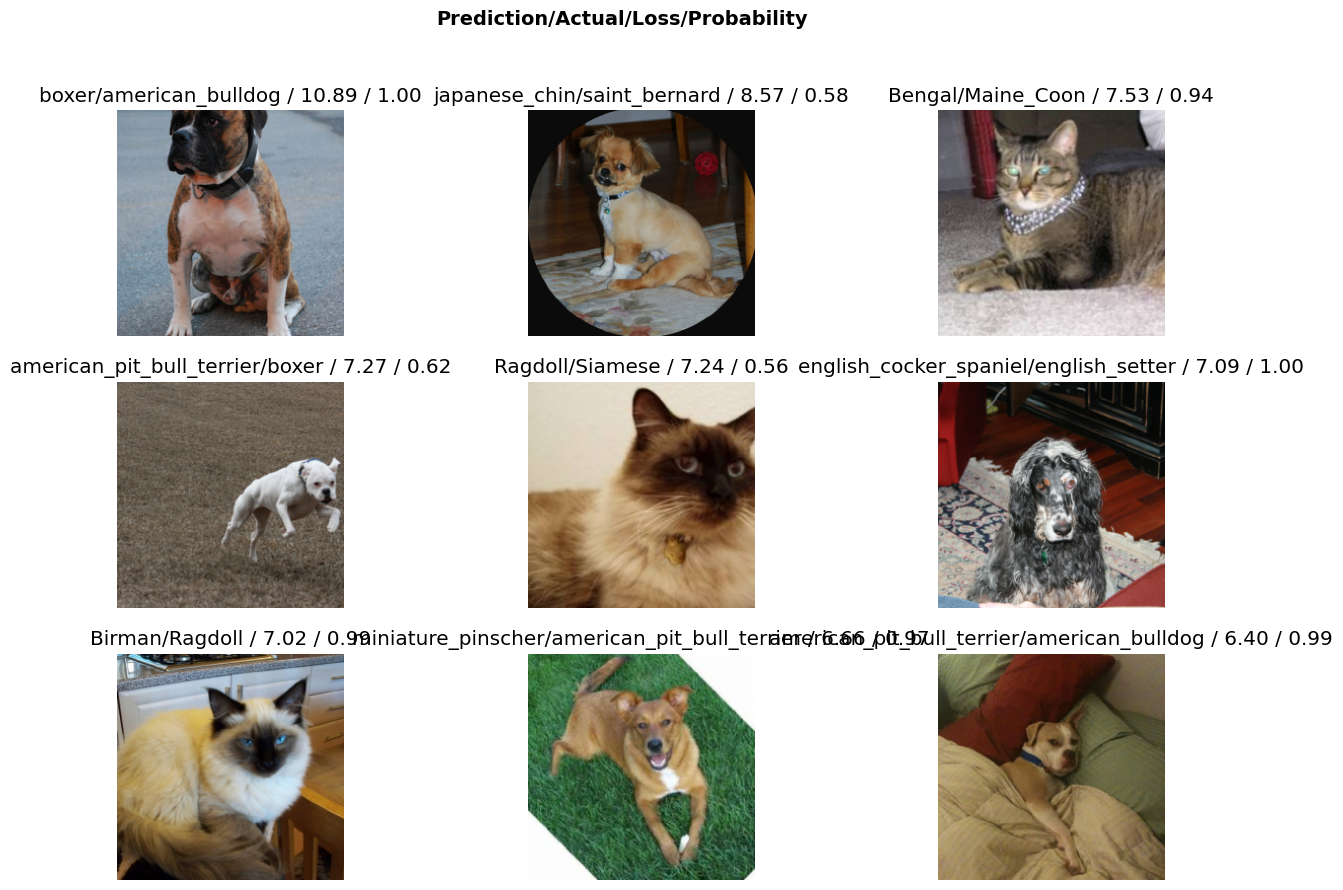

In [34]:
interp.plot_top_losses(9, figsize=(15,10))

## Deep Learning Is Not Just for Image Classification

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

In [ ]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

If you hit a "CUDA out of memory error" after running this cell, click on the menu Kernel, then restart. Instead of executing the cell above, copy and paste the following code in it:

```
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', bs=32)
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)
```

This reduces the batch size to 32 (we will explain this later). If you keep hitting the same error, change 32 to 16.

In [ ]:
learn.predict("I really liked that movie!")

### Sidebar: The Order Matters

### End sidebar

In [ ]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(3)

In [ ]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

In [ ]:
learn.show_results()

## Questionnaire

It can be hard to know in pages and pages of prose what the key things are that you really need to focus on and remember. So, we've prepared a list of questions and suggested steps to complete at the end of each chapter. All the answers are in the text of the chapter, so if you're not sure about anything here, reread that part of the text and make sure you understand it. Answers to all these questions are also available on the [book's website](https://book.fast.ai). You can also visit [the forums](https://forums.fast.ai) if you get stuck to get help from other folks studying this material.

For more questions, including detailed answers and links to the video timeline, have a look at Radek Osmulski's [aiquizzes](http://aiquizzes.com/howto).

1. Do you need these for deep learning?

   - Lots of math T / F
   - Lots of data T / F
   - Lots of expensive computers T / F
   - A PhD T / F
   
1. Name five areas where deep learning is now the best in the world.
1. What was the name of the first device that was based on the principle of the artificial neuron?
1. Based on the book of the same name, what are the requirements for parallel distributed processing (PDP)?
1. What were the two theoretical misunderstandings that held back the field of neural networks?
1. What is a GPU?
1. Open a notebook and execute a cell containing: `1+1`. What happens?
1. Follow through each cell of the stripped version of the notebook for this chapter. Before executing each cell, guess what will happen.
1. Complete the Jupyter Notebook online appendix.
1. Why is it hard to use a traditional computer program to recognize images in a photo?
1. What did Samuel mean by "weight assignment"?
1. What term do we normally use in deep learning for what Samuel called "weights"?
1. Draw a picture that summarizes Samuel's view of a machine learning model.
1. Why is it hard to understand why a deep learning model makes a particular prediction?
1. What is the name of the theorem that shows that a neural network can solve any mathematical problem to any level of accuracy?
1. What do you need in order to train a model?
1. How could a feedback loop impact the rollout of a predictive policing model?
1. Do we always have to use 224×224-pixel images with the cat recognition model?
1. What is the difference between classification and regression?
1. What is a validation set? What is a test set? Why do we need them?
1. What will fastai do if you don't provide a validation set?
1. Can we always use a random sample for a validation set? Why or why not?
1. What is overfitting? Provide an example.
1. What is a metric? How does it differ from "loss"?
1. How can pretrained models help?
1. What is the "head" of a model?
1. What kinds of features do the early layers of a CNN find? How about the later layers?
1. Are image models only useful for photos?
1. What is an "architecture"?
1. What is segmentation?
1. What is `y_range` used for? When do we need it?
1. What are "hyperparameters"?
1. What's the best way to avoid failures when using AI in an organization?

### Further Research

Each chapter also has a "Further Research" section that poses questions that aren't fully answered in the text, or gives more advanced assignments. Answers to these questions aren't on the book's website; you'll need to do your own research!

1. Why is a GPU useful for deep learning? How is a CPU different, and why is it less effective for deep learning?
1. Try to think of three areas where feedback loops might impact the use of machine learning. See if you can find documented examples of that happening in practice.